In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

data = pd.read_csv('city_market_tracker.tsv', sep='\t')
data = data.sort_values('period_begin')

In [2]:
def lagrange_interpolation(x, y):
    """
    Returns a function that evaluates the Lagrange polynomial defined by given nodes.
    
    Parameters:
    - x_nodes: 1D array-like of interpolation nodes
    - y_nodes: 1D array-like of function values at the nodes
    
    Returns:
    - A function P(x_val) that evaluates the Lagrange polynomial at x_val.
    """
    x_nodes = np.array(x)
    y_nodes = np.array(y)
    n = len(x_nodes)
    
    def P(x_val):
        total = 0
        for j in range(n):
            term = y_nodes[j]
            for i in range(n):
                if i != j:
                    term *= (x_val - x[i]) / (x[j] - x[i])
            total += term
        return total
    
    return P

def plot_city(data, city_name, state_code):
    """
    Plots Cubic Spline and Lagrange interpolation (using Chebyshev nodes) for a given city's 
    median sale price over time.

    Parameters:
    - data: DataFrame containing house pricing data.
    - city_name: String, name of the city to filter and plot.
    - state_code: String, state abbreviation (e.g., 'CO' for Colorado) to disambiguate cities.
    - num_nodes: Number of Chebyshev nodes to use for the Lagrange interpolation.
    
    Returns:
    - None (displays a plot)
    """
    # Filter data for the selected city and state
    city_data = data[(data['city'] == city_name) & (data['state_code'] == state_code)].copy()
    if city_data.empty:
        print(f"No data available for {city_name}, {state_code}.")
        return
    
    # Get the number of entries for Chebyshev Nodes
    num_nodes = len(city_data)

    # Convert period_begin to datetime and sort data
    city_data['period_begin'] = pd.to_datetime(city_data['period_begin'])
    city_data = city_data.sort_values('period_begin')

    # Remove duplicate dates by averaging sale prices
    city_data = city_data.groupby('period_begin', as_index=False)['median_sale_price'].mean()

    # Convert dates to numerical format (ordinal numbers)
    x = city_data['period_begin'].map(pd.Timestamp.toordinal).values
    y = city_data['median_sale_price'].values

    # Check if x is strictly increasing
    if np.any(np.diff(x) <= 0):
        print(f"Warning: Non-increasing x values detected in {city_name}, {state_code}. Skipping.")
        return

    # Fit cubic spline interpolation (passes through all points)
    cubic_spline = CubicSpline(x, y, bc_type='natural')

    # Determine number of Chebyshev nodes (use all data points if fewer than num_nodes)
    n_nodes = min(num_nodes, len(x))
    a, b = x.min(), x.max()

    # Compute Chebyshev nodes in [a, b]
    k = np.arange(n_nodes)
    cheb_nodes = 0.5*(a + b) + 0.5*(b - a) * np.cos((2*k + 1) / (2*n_nodes) * np.pi)
    
    # Get the corresponding y values at Chebyshev nodes using linear interpolation on the original data
    cheb_values = np.interp(cheb_nodes, x, y)

    # Create Lagrange interpolation function using Chebyshev nodes and their corresponding values
    lagrange_poly = lagrange_interpolation(cheb_nodes, cheb_values)

    # Generate smooth x values for plotting
    x_smooth = np.linspace(a, b, 500)
    y_cubic = cubic_spline(x_smooth)  # Evaluate cubic spline
    # Evaluate Lagrange polynomial at each smooth x value
    y_lagrange = np.array([lagrange_poly(val) for val in x_smooth])

    # Convert smooth x values back to datetime for plotting
    dates_smooth = [pd.Timestamp.fromordinal(int(val)) for val in x_smooth]

    # Plot original data points
    plt.figure(figsize=(12, 6))
    plt.plot(city_data['period_begin'], city_data['median_sale_price'], color='black', marker='o', linestyle='-', linewidth=2, label='Real Data', alpha=0.75)

    # Plot cubic spline
    plt.plot(dates_smooth, y_cubic, color='red', linestyle='--', linewidth=1, label='Cubic Spline Interpolation')

    # Plot Lagrange interpolation (using Chebyshev nodes)
    plt.plot(dates_smooth, y_lagrange, color='blue', linestyle='--', linewidth=1, label=f'Lagrange Interpolation (Chebyshev, n={n_nodes})')

    # Formatting
    plt.xlabel('Year')
    plt.ylabel('Median Sale Price ($)')
    plt.title(f'Comparison of Cubic Spline vs. Lagrange (Chebyshev) Interpolation in {city_name}, {state_code}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()

major regions

- west coast
    - San Francisco, CA
    - Los Angeles, CA
    - Sacramento, CA
    - Seattle, WA
    - Las Vegas, NV
    - Portland, OR
- east coast
    - New York, NY
    - Boston, MA
    - Miami, FL
- midwest
    - Denver, CO
    - Boulder, CO
    - Albuquerque, NM
    - Salt Lake City, UT
- south
    - New Orleans, LA
    - Atlanta, GA
    - Nashville, TN
    - Houston, TX
- great lakes
    - Detroit, MI
    - Chicago, IL
    - Cleveland, OH

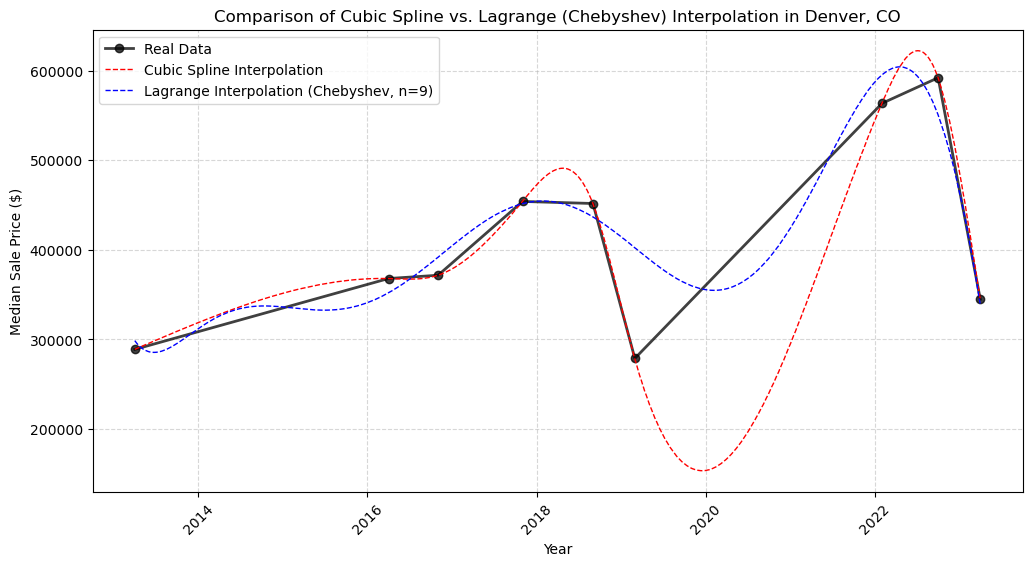

In [21]:
city = 'Denver'
code = 'CO'

plot_city(data, city, code)

/opt/conda/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


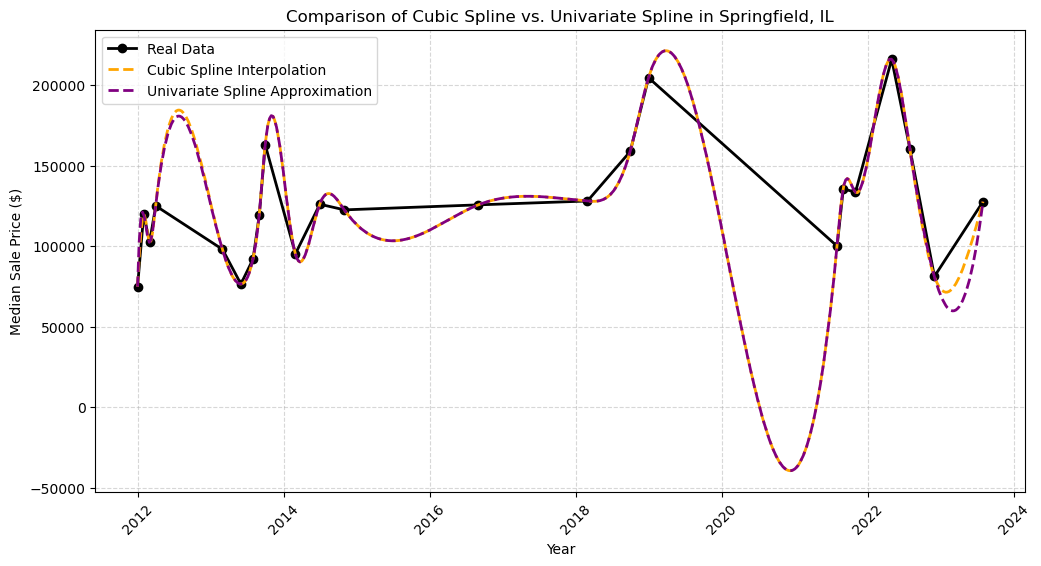

In [8]:
# city = 'Springfield'
# code = 'IL'

# search = data[(data['city'] == city) & (data['state_code'] == code)]

# # Plot median sale price over time
# plt.figure(figsize=(12, 6))
# plt.plot(search['period_begin'], search['median_sale_price'], marker='o', linestyle='-', label='sale price')
# # plt.plot(search['period_begin'], search['median_list_price'], marker='o', linestyle='-', label='list price')

# # Formatting the plot
# plt.xlabel('Period')
# plt.ylabel('Median Sale Price')
# plt.title(f'Median Sale Price Over Time in {city}, {code}')
# plt.xticks(rotation=45)
# plt.grid(True)

# plt.legend()
# # Show plot
# plt.show()

# plot_city_spline(data, city, code)

# fig, ax1 = plt.subplots(figsize=(12, 6))

# # Plot median sale price on primary y-axis
# ax1.plot(search['period_begin'], search['median_sale_price'], marker='o', linestyle='-', color='b', label='Median Sale Price')
# ax1.set_xlabel('Period Begin')
# ax1.set_ylabel('Median Sale Price ($)', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# # Create secondary y-axis for median price per square foot
# ax2 = ax1.twinx()
# ax2.plot(search['period_begin'], search['median_ppsf'], marker='s', linestyle='--', color='r', label='Median Price per Sq Ft')
# ax2.set_ylabel('Median Price per Sq Ft ($)', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# # Formatting
# fig.suptitle(f'Comparison of Median Sale Price and Price per Sq Ft in {city}, {code}')
# ax1.grid(True, linestyle='--', alpha=0.5)

# # Legends
# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# # Show plot
# plt.show()